---
title: "Stable Diffusion Inference with Diffusers (low-level)"
author: "Mingyu Jeon"
date: "2023-9-10"
categories: [deep learning, python]
---

# Stable Diffusion Inference (low-level)

Create an image using [Diffusers library](https://github.com/huggingface/diffusers).

## Install and Import Libraries

In [ ]:
#| output: false
!pip install -qq diffusers transformers scipy ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.4 MB/s eta 0:00:00


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion

num_inference_steps = 50  # Number of denoising steps

guidance_scale = 7.5  # Scale for classifier-free guidance

generator = torch.manual_seed(256)  # Seed generator to create the inital latent noise

batch_size = 2

In [ ]:
#| output: false
from diffusers import LMSDiscreteScheduler, StableDiffusionPipeline

scheduler = LMSDiscreteScheduler.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="scheduler"
)
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", scheduler=scheduler
)

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.20.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "LMSDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
pipe = pipe.to(device)

## Low-level

In [ ]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = pipe.vae

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

# 3. The UNet model for generating the latents.
unet = pipe.unet

### Models

In [ ]:
vae

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, ep

In [ ]:
tokenizer

CLIPTokenizer(name_or_path='/root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/133a221b8aa7292a167afc5127cb63fb5005638b/tokenizer', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True)

In [ ]:
text_encoder

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [ ]:
unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features

### Inference

In [ ]:
text_input = tokenizer(
    prompt * batch_size,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
).input_ids.to(device)

text_input.shape, text_input

(torch.Size([2, 77]),
 tensor([[49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407],
         [49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 

In [ ]:
with torch.no_grad():
    text_embeddings = text_encoder(text_input)[0]

text_embeddings.shape, text_embeddings

(torch.Size([2, 77, 768]),
 tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
          [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
          [ 0.4595,  0.5617,  1.6663,  ..., -1.9515, -1.2307,  0.0104],
          ...,
          [-3.0421, -0.0656, -0.1793,  ...,  0.3943, -0.0190,  0.7664],
          [-3.0551, -0.1036, -0.1936,  ...,  0.4236, -0.0190,  0.7575],
          [-2.9854, -0.0832, -0.1715,  ...,  0.4355,  0.0095,  0.7485]],
 
         [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
          [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
          [ 0.4595,  0.5617,  1.6663,  ..., -1.9515, -1.2307,  0.0104],
          ...,
          [-3.0421, -0.0656, -0.1793,  ...,  0.3943, -0.0190,  0.7664],
          [-3.0551, -0.1036, -0.1936,  ...,  0.4236, -0.0190,  0.7575],
          [-2.9854, -0.0832, -0.1715,  ...,  0.4355,  0.0095,  0.7485]]],
        device='cuda:0'))

In [ ]:
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=text_input.shape[-1],
    return_tensors="pt",
).input_ids.to(device)

uncond_input.shape, uncond_input

(torch.Size([2, 77]),
 tensor([[49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407],
         [49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 

In [ ]:
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input)[0]

uncond_embeddings.shape, uncond_embeddings

(torch.Size([2, 77, 768]),
 tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
          [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
          [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
          ...,
          [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
          [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
          [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],
 
         [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
          [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
          [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
          ...,
          [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
          [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
          [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]]],
        device='cuda:0'))

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

text_embeddings.shape, text_embeddings

(torch.Size([4, 77, 768]),
 tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
          [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
          [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
          ...,
          [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
          [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
          [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],
 
         [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
          [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
          [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
          ...,
          [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
          [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
          [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],
 
         [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
 

In [ ]:
#| warning: false
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
).to(device)

latents.shape, latents

<ipython-input-17-141c9c54f637>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


(torch.Size([2, 4, 64, 64]),
 tensor([[[[ 0.1884, -0.6394,  0.1089,  ..., -0.9887, -0.7133, -1.1545],
           [ 0.4124,  1.5587, -0.3407,  ...,  2.1968, -0.0356, -0.0810],
           [-1.8912,  0.0528, -0.4425,  ...,  1.3110,  0.7100,  0.6802],
           ...,
           [-1.3443, -0.1747, -0.6298,  ...,  0.4572, -0.8584, -0.1284],
           [-1.7920, -0.6554, -0.0439,  ...,  0.5436,  2.2266, -0.5003],
           [ 0.6213, -1.3155,  0.7470,  ..., -0.2354,  0.7097,  0.6170]],
 
          [[-0.5007, -1.4418,  0.2598,  ..., -0.2586,  2.3239, -1.3245],
           [ 0.8540, -0.4135,  0.5658,  ..., -1.9556,  2.0454, -0.2454],
           [-0.3212, -1.9329, -1.1598,  ...,  0.7156, -0.7228, -0.6992],
           ...,
           [ 0.0180, -0.7993,  2.3330,  ...,  0.2594, -0.0333, -0.0826],
           [-1.2569, -0.8219,  1.3467,  ...,  0.4792,  1.8265, -0.6156],
           [-1.9367, -0.0949,  0.0720,  ...,  0.0806,  0.2966, -1.0284]],
 
          [[ 0.2291, -0.0936, -1.3283,  ...,  1.4995, -0.

In [ ]:
scheduler.set_timesteps(num_inference_steps)

scheduler.timesteps.shape, pipe.scheduler.timesteps

(torch.Size([50]),
 tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490, 897.0612, 876.6735,
         856.2857, 835.8980, 815.5102, 795.1224, 774.7347, 754.3469, 733.9592,
         713.5714, 693.1837, 672.7959, 652.4082, 632.0204, 611.6327, 591.2449,
         570.8571, 550.4694, 530.0816, 509.6939, 489.3061, 468.9184, 448.5306,
         428.1429, 407.7551, 387.3673, 366.9796, 346.5918, 326.2041, 305.8163,
         285.4286, 265.0408, 244.6531, 224.2653, 203.8776, 183.4898, 163.1020,
         142.7143, 122.3265, 101.9388,  81.5510,  61.1633,  40.7755,  20.3878,
           0.0000], dtype=torch.float64))

### Classifier-free guidance (CFG)

$$
\tilde{\boldsymbol{\epsilon}}_\theta(\mathbf{z}_t, \mathbf{c}) = w\boldsymbol{\epsilon}_\theta(\mathbf{z}_t, \mathbf{c}) + (1-w)\boldsymbol{\epsilon}_{\theta}(\mathbf{z}_t).
$$

Here, $\boldsymbol{\epsilon}_\theta(\mathbf{z}_t, \mathbf{c})$ and $\boldsymbol{\epsilon}_{\theta}(\mathbf{z}_t)$ are conditional and unconditional $\boldsymbol{\epsilon}$-predictions, given by $\boldsymbol{\epsilon}_\theta := (\mathbf{z}_t - \alpha_t\hat{\mathbf{x}}_\theta)/\sigma_t$, and $w$ is the *guidance weight*. Setting $w = 1$ disables classifier-free guidance, while increasing $w > 1$ strengthens the effect of guidance.[^1]

[^1]: Saharia et al. (2022) Photorealistic Text-to-Image Diffusion Models with Deep Language Understanding, <https://arxiv.org/pdf/2205.11487.pdfSaharia>

In [ ]:
#| output: false
from tqdm.auto import tqdm

latents = latents * scheduler.init_noise_sigma

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input, t, encoder_hidden_states=text_embeddings
        ).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = (
        guidance_scale * noise_pred_text + (1 - guidance_scale) * noise_pred_uncond
    )

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

In [ ]:
from PIL import Image

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

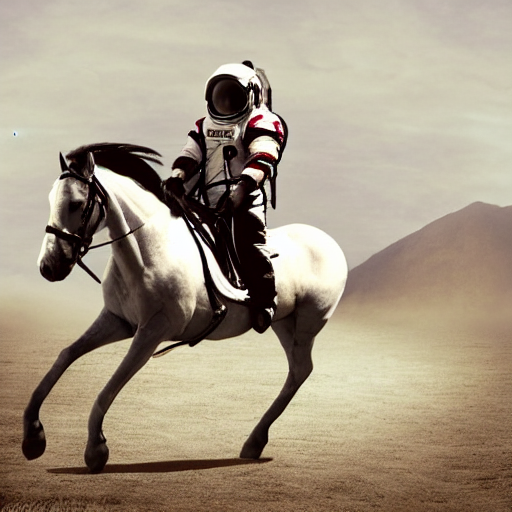

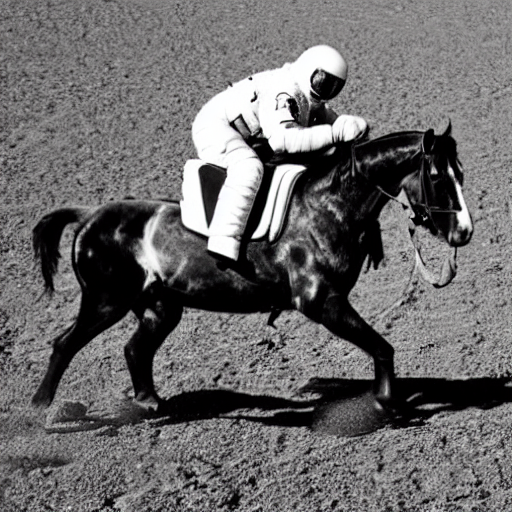

In [ ]:
for pil_image in pil_images:
    display(pil_image)

## References
- Patil et al. (2022) Stable Diffusion with 🧨 Diffusers, <https://huggingface.co/blog/stable_diffusion>
- <a target="_blank" href="https://colab.research.google.com/github/mgjeon/notebooks/blob/main/Stable_Diffusion_Interence/Stable_Diffusion_Inference_high_level.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>